### Supplementary Information: Holmes *et al.* 2017

# 13. Hierarchical treatment intercept - locus tag - control slope

In [2]:
%pylab inline

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

This model uses only draws the estimate of the intercepts $\alpha_{j[i]}$ and $\gamma_{j[i]}$ from a pooled distribution.

This may be an appropriate model, biologically-speaking, as we are assuming unique 'selection' contributions to the relationship due either to the growth/*control* and the passage/*treatment* steps

We construct the following model of the experiment:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \gamma_{j[i]} t_i + \delta_{j[i]} t_i x_i + \epsilon_i$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\gamma_{j[i]} \sim N(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\gamma} \sim U(0, 100)$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $t_i$: 0/1 indicating whether the probe $i$ was measured in a control (0) or treatment (1) experiment
* $\alpha_{j[i]}$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements, but it differs for each *probe ID*; this is drawn from a Normal distribution $\sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$
* $\mu_{\alpha}$: the mean offset for all *probe ID*s
* $\sigma_{\alpha}$: the standard deviation of the offset for all *probe ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *probe ID*; this is drawn from a Normal distribution $\sim N(\mu_{\beta}, \sigma_{\beta}^2)$
* $\gamma_{j[i]}$: a groupwise estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment (i.e. an intercept correction)
* $\mu_{\gamma}$: the mean intercept due to *treatment* for each *probe ID*
* $\sigma_{\gamma}$: the standard deviation of the offset for each *probe ID* due to the *treatment* - sampled from a Uniform distribution $U(0, 100)$
* $\delta_{j[i]}$: a groupwise estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment, as a function of the *input* measured intensity (i.e. a slope correction)
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points)
* `J`: `int`, the number of unique locus tags (`J` < `N`)
* `tag`: `int[N]`, an index list of locus tag identities
* `t`: `vector[N]`, 0/1 control/treatment values for each probe
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, representative input log(intensity)
* `mu_a`: `real`, an unconstrained value to be fit that represents the mean offset for each locus tag
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a locus tag
* `g`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (offset)
* `mu_g`: `real`, an unconstrained value to be fit that represents the mean offset for each locus tag due to *treatment*
* `d`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (slope)
* `sigma`: `real<lower=0>`, the error in the prediction
* `sigma_a`: `real<lower=0,upper=100>`, standard deviation of the offset per locus tag
* `sigma_g`: `real<lower=0,upper=100>`, standard deviation of the offset per locus tag due to *treatment*

We also define a `transformed parameter`:

* `y_hat[i] <- b[tag[i]] * x[i] + a[tag[i]] + g[tag[i]] * t[i] + d[tag[i]] * t[i] * x[i]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as:

$$\sigma_{\alpha} \sim U(0, 100)$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\gamma_{j[i]} \sim N(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$y \sim N(\hat{y}, \sigma^2)$$


In [5]:
# load clean, normalised, indexed data
data = pd.read_csv("output/normalised_indexed_array_data.tab", sep="\t")  # full dataset
#data = pd.read_csv("output/reduced_normalised_locus_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
tag_ids = data['locus_tag'].unique()
ntags = len(tag_ids)

In [ ]:
# define unpooled stan model
treatment_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> tag[N];
  vector[N] t;
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  vector[J] g;
  vector[J] d;
  real mu_a;
  real mu_g;  
  real<lower=0> sigma;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_g;  
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[tag[i]] + b[tag[i]] * x[i] + g[tag[i]] * t[i] + d[tag[i]] * t[i] * x[i];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal(mu_a, sigma_a);

  sigma_g ~ uniform(0, 100);
  g ~ normal(mu_g, sigma_g);

y ~ normal(y_hat, sigma);
}
"""

In [ ]:
# relate python variables to stan variables
treatment_data_dict = {'N': len(data),
                       'J': ntags,
                       'tag': data['locus_index'] + 1,
                       't': data['treatment'],
                       'x': data['log_input'],
                       'y': data['log_output']}

In [ ]:
# run stan fit
treatment_fit = pystan.stan(model_code=treatment_model,
                            data=treatment_data_dict,
                            iter=1000, chains=2,
                            seed=tools.SEED)

In [ ]:
# Save fit to file, for reuse
unpermutedChains = treatment_fit.extract()

unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
pickle.dump(unpermutedChains_df, open('output/2016-12-05_notebook13_full_data.pkl', 'wb'))

In [3]:
treatment_fit = pickle.load(open('output/2016-12-05_notebook13_full_data.pkl', 'rb'))

## Inspecting the fit

Our primary interest now returns to groupwise values, but this time of the effect due to the *treatment* in the experiment.

In [ ]:
# Get fits to alpha, beta, gamma by probe ID
alpha_estimates = pd.Series(treatment_fit['a'].mean(0), index=tag_ids)
alpha_se = pd.Series(treatment_fit['a'].std(0), index=tag_ids)
beta_estimates = pd.Series(treatment_fit['b'].mean(0), index=tag_ids)
beta_se = pd.Series(treatment_fit['b'].std(0), index=tag_ids)
gamma_estimates = pd.Series(treatment_fit['g'].mean(0), index=tag_ids)
gamma_se = pd.Series(treatment_fit['g'].std(0), index=tag_ids)
delta_estimates = pd.Series(treatment_fit['d'].mean(0), index=tag_ids)
delta_se = pd.Series(treatment_fit['d'].std(0), index=tag_ids)

In [6]:
# Get fits to alpha, beta, gamma by probe ID
alpha_estimates = pd.Series(treatment_fit['a'][0].mean(0), index=tag_ids)
alpha_se = pd.Series(treatment_fit['a'][0].std(0), index=tag_ids)
beta_estimates = pd.Series(treatment_fit['b'][0].mean(0), index=tag_ids)
beta_se = pd.Series(treatment_fit['b'][0].std(0), index=tag_ids)
gamma_estimates = pd.Series(treatment_fit['g'][0].mean(0), index=tag_ids)
gamma_se = pd.Series(treatment_fit['g'][0].std(0), index=tag_ids)
delta_estimates = pd.Series(treatment_fit['d'][0].mean(0), index=tag_ids)
delta_se = pd.Series(treatment_fit['d'][0].std(0), index=tag_ids)

In [ ]:
# Inspect the estimates
alpha_estimates.head()

In [ ]:
# Inspect the estimates
beta_estimates.head()

In [ ]:
# Inspect the estimates
gamma_estimates.head()

In [ ]:
# Inspect the estimates
delta_estimates.head()

### Intercepts $\alpha_{j[i]}$

In [ ]:
# Plot means distribution
g = sns.boxplot(alpha_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(alpha)");

In [ ]:
# Plot errors distribution
g = sns.boxplot(alpha_se)
g.set_title("Distribution of intercept standard error")
g.set_xlabel("se(alpha)");

In [ ]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, 1.5)

In [ ]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, -0.1, upper=False)

### Slopes $\beta_{j[i]}$

In [ ]:
# Plot means distribution
g = sns.boxplot(beta_estimates)
g.set_title("Distribution of mean slope")
g.set_xlabel("mean(beta)");

In [ ]:
# Plot errors distribution
g = sns.boxplot(beta_se)
g.set_title("Distribution of slope standard error")
g.set_xlabel("se(beta)");

In [ ]:
# errors for intercept outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 0.99)

In [ ]:
# errors for intercept outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 0.75, upper=False)

### Intercepts $\gamma_{j[i]}$

In [ ]:
# Plot means distribution
g = sns.boxplot(gamma_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(gamma)");

In [ ]:
# Plot errors distribution
g = sns.boxplot(gamma_se)
g.set_title("Distribution of intercept standard error")
g.set_xlabel("se(gamma)");

In [ ]:
# errors for intercept outliers
tools.plot_threshold_errors(gamma_estimates, gamma_se, 1.5)

In [ ]:
# errors for intercept outliers
tools.plot_threshold_errors(gamma_estimates, gamma_se, -0.1, upper=False)

### Slopes $\delta_{j[i]}$

In [ ]:
# Plot means distribution
g = sns.boxplot(delta_estimates)
g.set_title("Distribution of mean slope")
g.set_xlabel("mean(delta)");

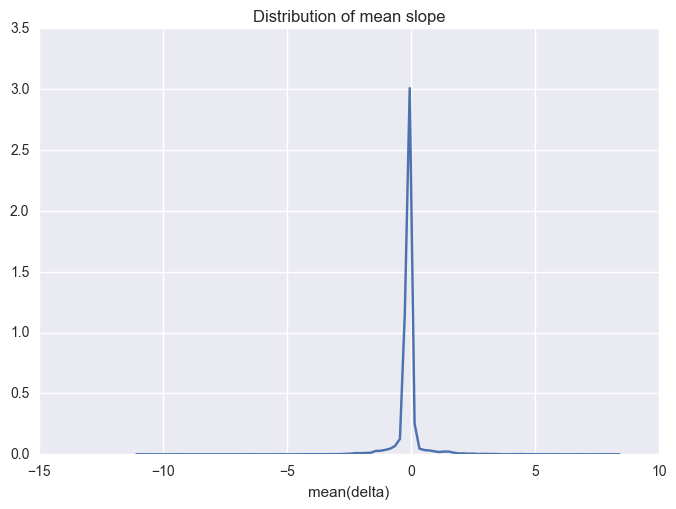

In [11]:
# Plot means distribution
g = sns.kdeplot(delta_estimates)
g.set_title("Distribution of mean slope")
g.set_xlabel("mean(delta)");
#g.set_xlim(-5, 5)

In [ ]:
# Plot errors distribution
g = sns.boxplot(delta_se)
g.set_title("Distribution of slope standard error")
g.set_xscale("log")
g.set_xlabel("se(delta)");

In [ ]:
# errors for intercept outliers
tools.plot_threshold_errors(delta_estimates, delta_se, 0.1)

In [ ]:
# errors for intercept outliers
tools.plot_threshold_errors(delta_estimates, delta_se, -0.2, upper=False)

In [ ]:
df_delta = pd.DataFrame({'treatment_mean': delta_estimates, 'treatment_error': delta_se})
df_delta.reset_index(inplace=True)
df_delta = df_delta.rename(columns={'index': 'locus_tag'})
df_delta = pd.merge(data, df_delta, 'inner', ['locus_tag'])
df_delta.head()
#positives_df.to_csv('2016-12-05_df_delta.tab', sep="\t", index=False)

In [ ]:
df_delta.plot('probe_index', 'treatment_mean', 'scatter', alpha=0.2);

In [8]:
df = pd.DataFrame({'mean': delta_estimates,
                   'error': delta_se})
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'locus_tag'})
df.sort_values('locus_tag', inplace=True)
df.head()

,locus_tag,error,mean
8052,ECDH10B_RS00010,0.600003,-0.097194
8046,ECDH10B_RS00015,0.641896,-0.154974
7424,ECDH10B_RS00020,0.523569,-0.135715
5580,ECDH10B_RS00030,0.491004,-0.047736
8041,ECDH10B_RS00035,0.542101,-0.143327


(0, 8532)

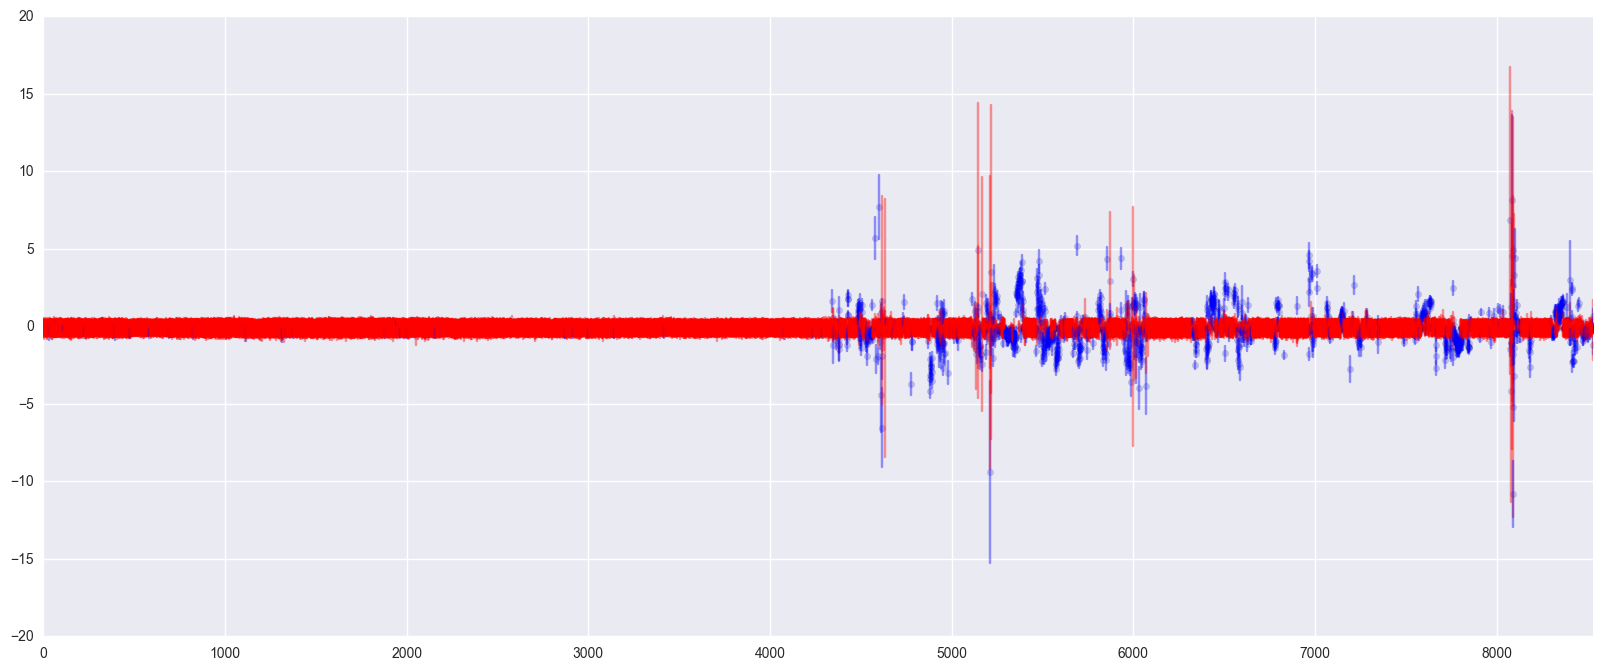

In [10]:
# plot ordered means and errors
plt.figure(figsize=(20,8))
plt.scatter(range(len(df)), df['mean'], alpha=0.2)
for idx, mn, se in zip(range(len(df)),
                       df['mean'], df['error']):
    if se > abs(mn):
        color = 'r-'
    else:
        color = 'b-'
    plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
plt.xlim(0, len(delta_estimates))
#plt.xlim(5000, 5500)


In [ ]:
len(data['locus_tag'].unique())